# Trabalho de AEDV (A1)
   
#### Dupla dinâmica: $(igor)^2 = -(gor)^2$
    Igor Cortes Junqueira
    Igor Patricio Michels

## Escolha da base de dados

O primeiro passo do trabalho foi a escolha da base de dados. Para tanto optamos por otimizar o tempo fazendo a escolha de uma base que pode nos porporcionar a escolha da próxima série a ser assistida. Dessa forma, escolhemos uma base do Kaggle com séries em diversas plataformas, a qual pode ser encontrada [aqui](https://www.kaggle.com/ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney).

Um problema dessa base é que ela não é muito informativa, isto é, uma das informações que consideramos de maior relevância, o gênero da série, não está presente nessa base. Dessa forma, buscamos novas bases de dados no Kaggle, uma da [Netflix](https://www.kaggle.com/shivamb/netflix-shows), uma da [Amazon Prime](https://www.kaggle.com/nilimajauhari/amazon-prime-tv-shows) e uma da [Disney Plus](https://www.kaggle.com/unanimad/disney-plus-shows), as quais possuem a indicação do gênero.

Para utilizar as 4 bases descritas, realizamos um merge entre elas a partir do título, incluindo o gênero da série na nossa base. As demais informações presentes nas últimas 3 bases foram descartadas, uma vez que nem todas tinham aquela informação. Da base original descartamos todos os títulos que estavam presentes apenas na plataforma Hulu, uma vez que esta plataforma não está disponível no Brasil.

Abaixo temos a preparação do ambiente, com a importação das bibliotecas utilizadas, bem como a importação das bancos de dados.

## Importação e limpeza dos dados

In [1]:
library(readr)
library(stringr)
library(rlist)
library(dplyr)
library(ggplot2)
shows <- read_csv("tv_shows.csv")
disney <- read_csv("disney_plus_shows.csv")
netflix <- read_csv("netflix_titles.csv")
prime <- read_csv("Prime TV Shows Data set.csv")

Warning message:
"package 'rlist' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Parsed with column specification:
cols(
  ID = col_character(),
  Title = col_character(),
  Year = col_double(),
  Age = col_character(),
  IMDb = col_double(),
  Rotten_Tomatoes = col_character(),
  Netflix = col_double(),
  Hulu = col_double(),
  Prime_Video = col_double(),
  DisneyPlus = col_double(),
  type = col_double()
)
Warning message:
"85 parsing failures.
row col   expected    actual           file
 63  -- 11 columns 1 columns 'tv_shows.csv'
 69  -- 11 columns 1 columns 'tv_shows.csv'
423  -- 11 columns 1 columns 'tv_shows.csv'
453  -- 11 columns 1 columns 'tv_shows.csv'
528  -- 11 c

Feito isso, iremos compor a base do trabalho, isto é, fazer o merge dos bancos utilizados, bem como a exclusão das séries exclusivas da Hulu.

In [2]:
# Limpando o databse conjunto para os dados relevantes

cshows <- shows %>% mutate(Streamings = paste(sep = " ", ifelse(Netflix == 1, "Netflix", ""),
                                                         ifelse(Prime_Video == 1, "Prime", ""),
                                                         ifelse(DisneyPlus == 1, "Disney", "")) %>%
                                        trimws() %>%
                                        str_replace(" ",", ")) %>%
                                        select(-Netflix, -Hulu, -Prime_Video, -DisneyPlus, -type, -ID)

cshows <- subset(cshows, Streamings != "NA, NA NA" & Streamings != "")
cshows <- cshows %>% mutate(Rotten_Tomatoes = as.numeric(sub("%", "", Rotten_Tomatoes)))

# Importanto Genero dos demais databases

t1 <- netflix %>% mutate(Title = title, Genre = listed_in) %>% select(Title, Genre) 
t2 <- prime %>% mutate(Title = ) %>% select(Title, Genre)
t3 <- disney %>% mutate(Title = title, Genre = genre) %>% select(Title, Genre)
gb <- c("Title", "Genre")
t <- full_join(t1, full_join(t2, t3, by = gb), by = gb)

cshows <- left_join(cshows, t, by = 'Title')
glimpse(cshows)

Rows: 4,143
Columns: 7
$ Title           <chr> "Breaking Bad", "Stranger Things", "Money Heist", "She~
$ Year            <dbl> 2008, 2016, 2017, 2010, 2015, 2005, 2011, 2005, 2005, ~
$ Age             <chr> "18+", "16+", "18+", "16+", "18+", "16+", "18+", "16+"~
$ IMDb            <dbl> 9.5, 8.8, 8.4, 9.1, 8.7, 8.9, 8.8, 8.4, 8.4, 8.8, 9.2,~
$ Rotten_Tomatoes <dbl> 96, 93, 91, 78, 97, 81, 83, 93, 93, 92, 100, 81, 94, 8~
$ Streamings      <chr> "Netflix", "Netflix", "Netflix", "Netflix", "Netflix",~
$ Genre           <chr> "Crime TV Shows, TV Dramas, TV Thrillers", "TV Horror,~


Como utilizamos 3 bases distintas para incluir o gênero da série, é natural que o gênero esteja totalmente despadronizado, dessa forma estamos criando uma lista de gêneros para facilitar nossas queries.

In [3]:
x <- ""
for(g in cshows[,'Genre'][[1]]){
    c <- str_replace_all(g,"TV","") %>%
         str_replace_all("Reality-", "Reality-Show") %>%
         str_replace_all("Sci-Fi", "Sci-fi") %>%
         str_replace_all("Sci-fi comedy", "") %>%
         str_replace_all(" &", ",") %>%
         str_replace_all("Movies", "") %>%
         str_replace_all("Shows", "") %>%
         str_replace_all("/", "") %>%
         str_replace_all("Mysteries", "Mystery") %>%
         str_replace_all("Comedies", "Comedy") %>%
         str_replace_all("Documentaries", "Documentary") %>%
         str_replace_all("Dramas", "Drama") %>%
         str_replace_all("Musicals", "Musical") %>%
         str_replace_all("Thrillers", "Thriller") %>%
         str_replace_all("Talk-Show", "") %>%
         str_replace_all("Romantic", "Romance") %>%
         str_replace_all("Anime Series", "Anime") %>%
         str_replace_all("Kids\'", "") %>%
         str_replace_all("Kids\'", "")

    x <- paste(x, trimws(c), sep = ",")
}

gens <- strsplit(x, ",")[[1]] %>%
        trimws() %>%
        unique()

gens <- gens[gens != ""]
gens

[1] "Crime"            "Drama"            "Thriller"         "Horror"          
 [5] "Mystery"          "Sci-fi"           "Fantasy"          "NA"              
 [9] "British"          "International"    "Comedy"           "Classic"         
[13] "Cult"             "Action"           "Adventure"        "Suspense"        
[17] "Anime"            "Romance"          "Spanish-Language" "Teen"            
[21] "Docuseries"       "Science"          "Nature"           "Reality"         
[25] "Documentary"      "Sports"           "Korean"           "Animation"       
[29] "Family"           "Musical"          "Independent"      "Stand-Up Comedy" 
[33] "Talk"             "Reality-Show"     "Game-Show"        "Kids"            
[37] "Children"         "Short"            "Music"            "Western"         
[41] "LGBTQ"            "Arts"             "Entertainment"    "Culture"

## Análise Exploratória

In [21]:
varpop <- function(x){
  n <- length(x)
  var(x)*(n-1)/n
}

In [4]:
plataforma <- table(cshows$Streamings)
plataforma


          Disney          Netflix Netflix,  Disney   Netflix, Prime 
             186             1832                8               93 
           Prime 
            2024 

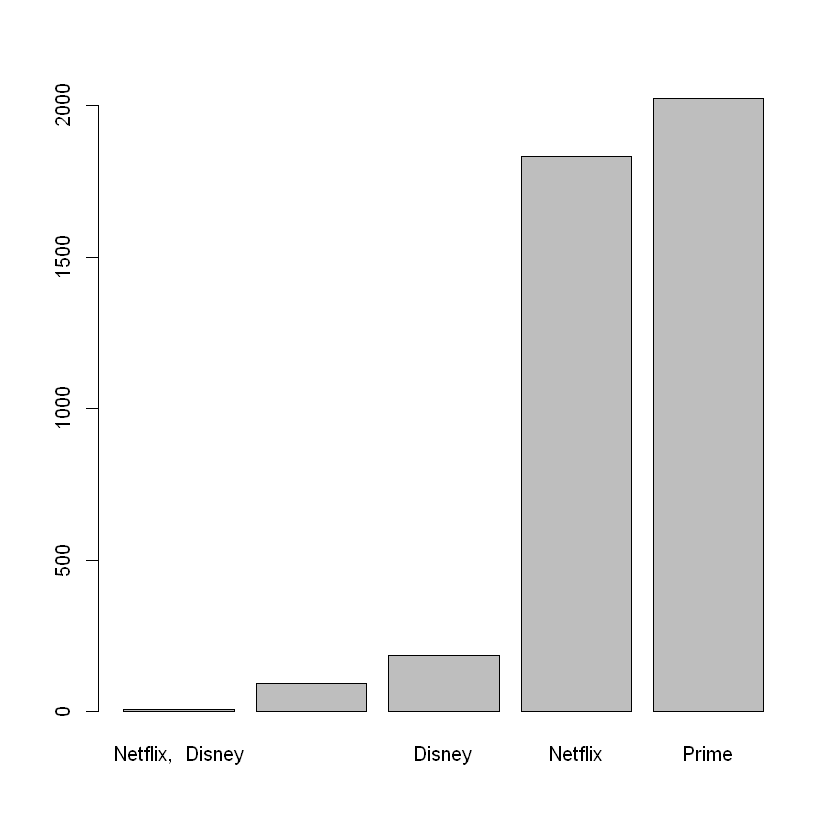

In [5]:
barplot(sort(plataforma))

In [6]:
plataforma <- prop.table(plataforma)
plataforma


          Disney          Netflix Netflix,  Disney   Netflix, Prime 
     0.044895004      0.442191649      0.001930968      0.022447502 
           Prime 
     0.488534878 

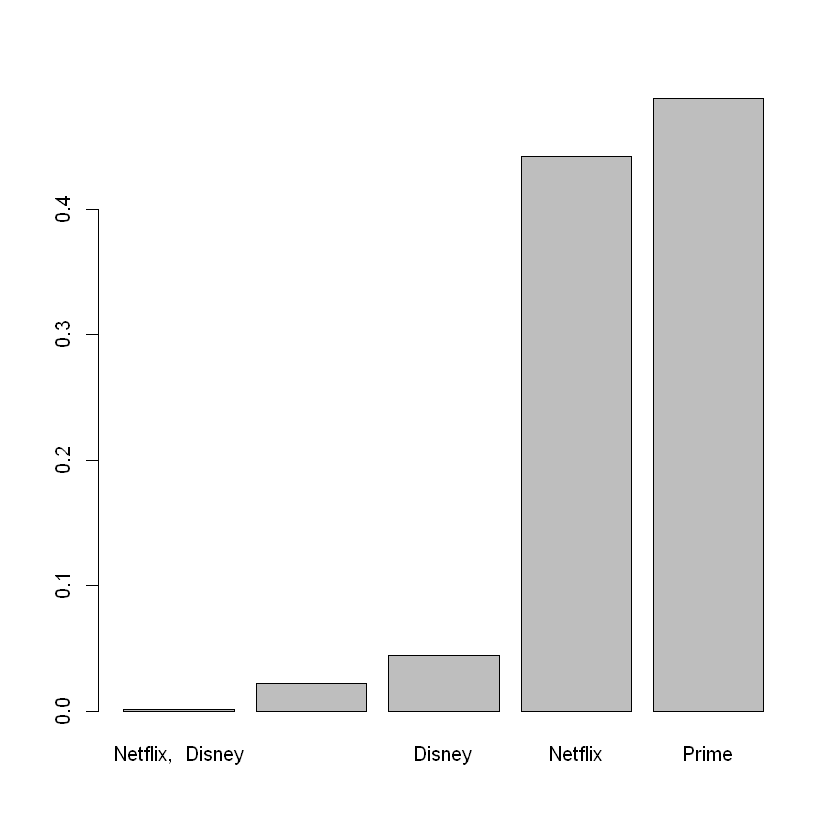

In [7]:
barplot(sort(plataforma))

Note que mais que 50% das séries disponíveis se encontram no Amazon Prime (48.85% da Amazon Prime e 2.24% que estão na Netflix e na Amazon Prime). Outro fato interessante é que o Disney Plus tem menos que 5% das séries e, além disso, nenhuma série se encontra no Disney Plus e na Amazon Prime simultaneamente.

Um outro dado de nosso interesse é a avaliação da crítica, dessa forma, analisando as notas, quanto ao IMDb, temos.

In [8]:
quantile(cshows[, "IMDb"], na.rm = TRUE)

0%  25%  50%  75% 100% 
 1.0  6.6  7.4  8.0  9.5

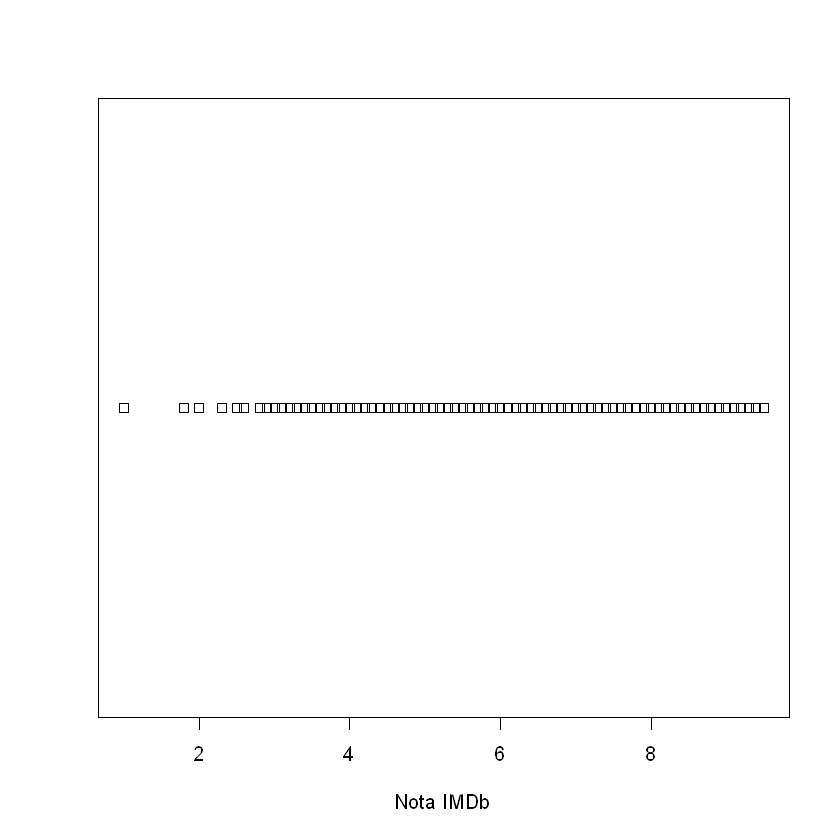

In [9]:
stripchart(cshows[, "IMDb"], xlab = "Nota IMDb")

Warning message:
"Removed 938 rows containing non-finite values (stat_boxplot)."

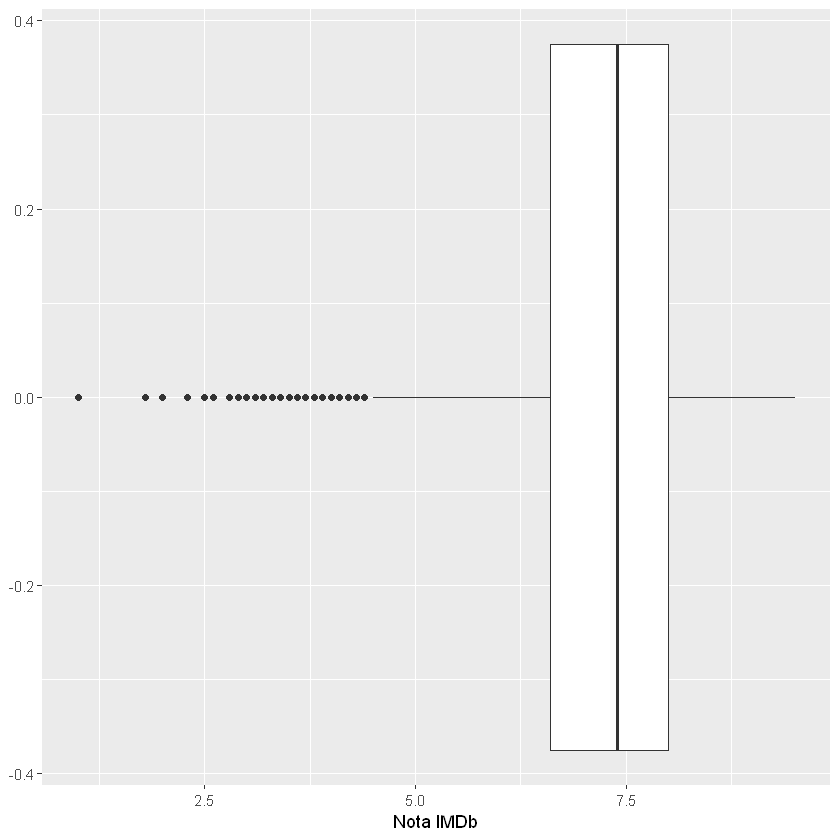

In [10]:
cshows %>% 
ggplot(aes(x = IMDb)) +
geom_boxplot() +
labs(x = "Nota IMDb")

Já de acordo com o Rotten Tomatoes

In [61]:
quantile(cshows[, "Rotten_Tomatoes"], na.rm = TRUE)

0%  25%  50%  75% 100% 
   6   67   84   93  100

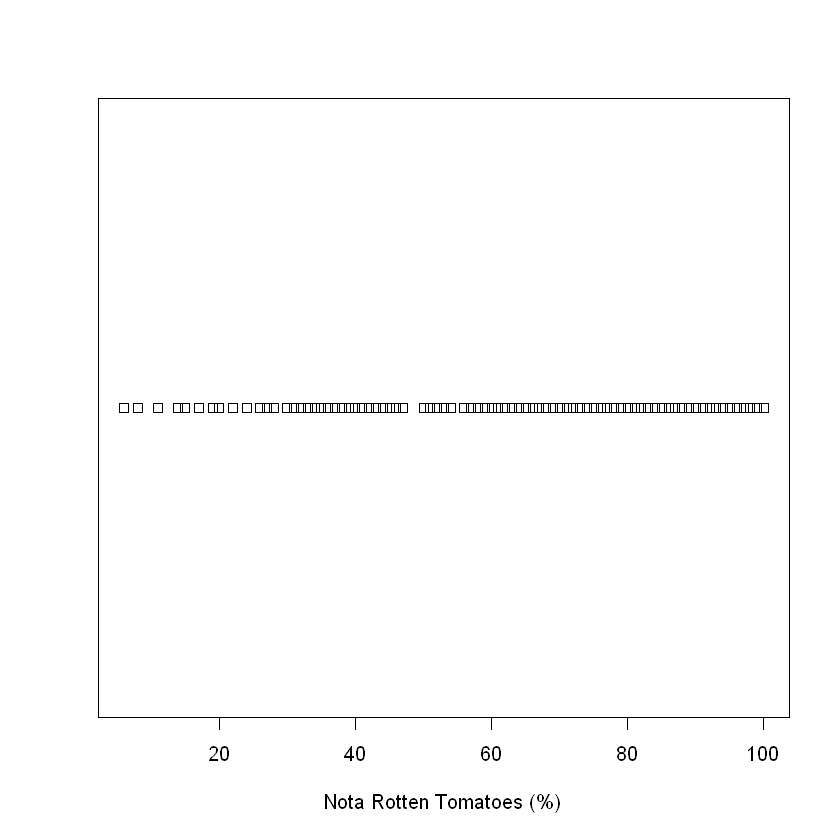

In [62]:
stripchart(cshows[, "Rotten_Tomatoes"], xlab = "Nota Rotten Tomatoes (%)")

Warning message:
"Removed 3435 rows containing non-finite values (stat_boxplot)."

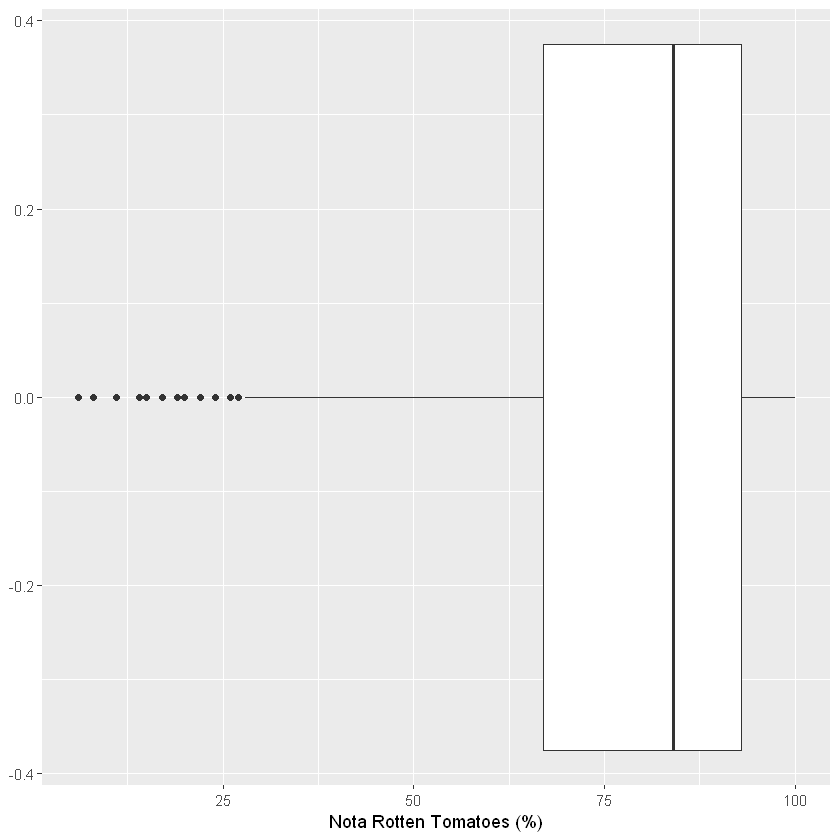

In [63]:
cshows %>% 
ggplot(aes(x = Rotten_Tomatoes)) +
geom_boxplot() +
labs(x = "Nota Rotten Tomatoes (%)")

Também é possível fazer algumas análises quanto as notas de acordo com a série, dando ênfase na plataforma de origem. Nos gráficos abaixo estão as melhores séries de 2020, por exemplo.

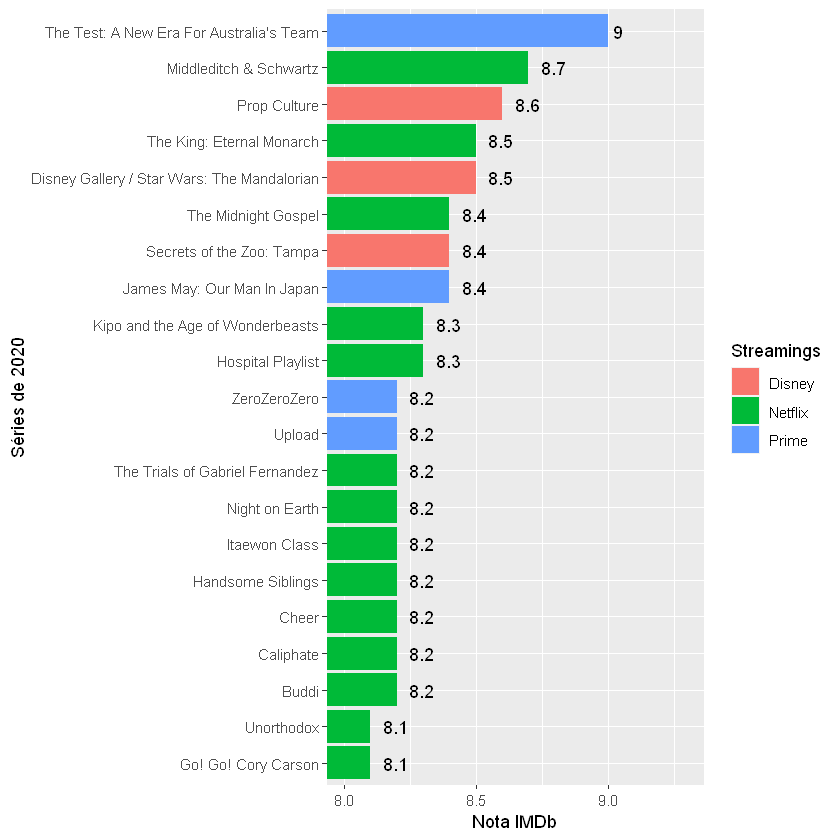

In [68]:
# Melhores séries de 2020 pelo IMDb (nota > 8)
cshows %>% filter(Year==2020, IMDb>8) %>% arrange(-IMDb) %>%
    ggplot(aes(reorder(Title,IMDb),IMDb)) + geom_col(aes(fill=Streamings)) +
    coord_flip(ylim=c(8,9.3)) + xlab("Séries de 2020") + ylab("Nota IMDb") +
    geom_text(aes(label = IMDb), hjust = -.5)

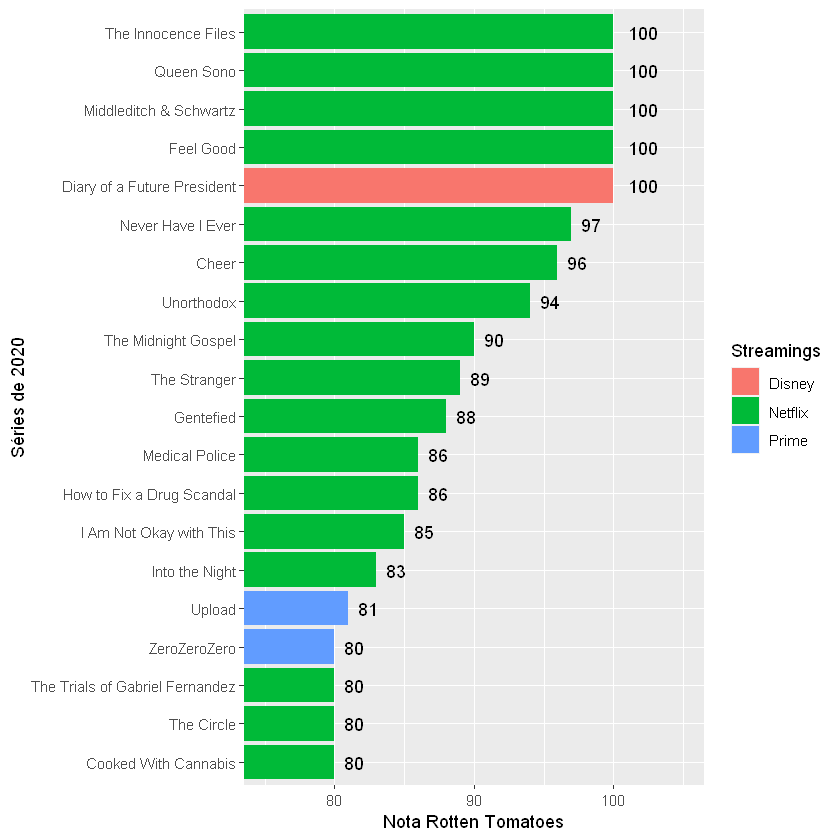

In [69]:
# Melhores séries de 2020 pelo Rotten Tomatoes (nota > 80)
cshows %>% filter(Year==2020, Rotten_Tomatoes>=80) %>%
    ggplot(aes(reorder(Title,Rotten_Tomatoes),Rotten_Tomatoes)) + geom_col(aes(fill=Streamings)) +
    coord_flip(ylim=c(75,105)) + xlab("Séries de 2020") + ylab("Nota Rotten Tomatoes") +
    geom_text(aes(label = Rotten_Tomatoes), hjust = -.5)

Outra análise interessante se dá pela faixa etária da série. Dessa forma, é possível também analisar a quantidade de títulos por faixa etária e plataforma

In [73]:
plataforma <- table(cshows$Streamings, cshows$Age)
plataforma

                  
                   13+ 16+ 18+  7+ all
  Disney             0   3   0  71  82
  Netflix            3 394 355 271 151
  Netflix,  Disney   0   0   0   4   4
  Netflix, Prime     0  17   4  26  17
  Prime              1 196 177 196 174

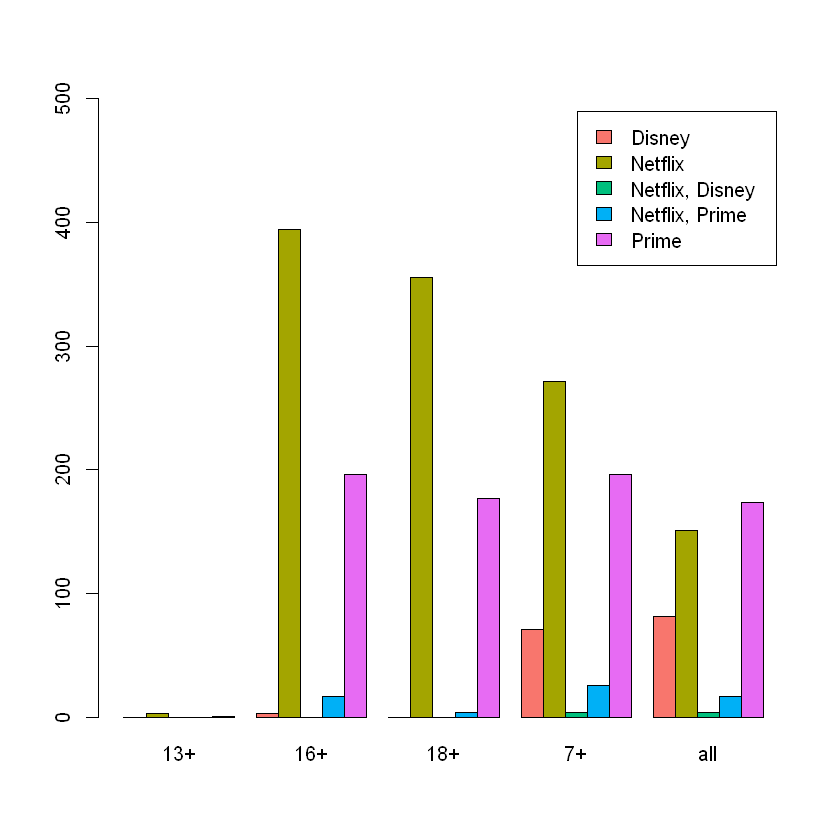

In [76]:
barplot(plataforma,
        beside = TRUE,
        legend.text = c("Disney", "Netflix", "Netflix, Disney", "Netflix, Prime", "Prime"),
        col = c("#f8766d", "#a3a500", "#00bf7d", "#00b0f6", "#e76bf3"),
        ylim = c(0, 500))

Uma outra visualização dos mesmos dados, mas com a inclusão de uma série temporal, se dá conforme abaixo

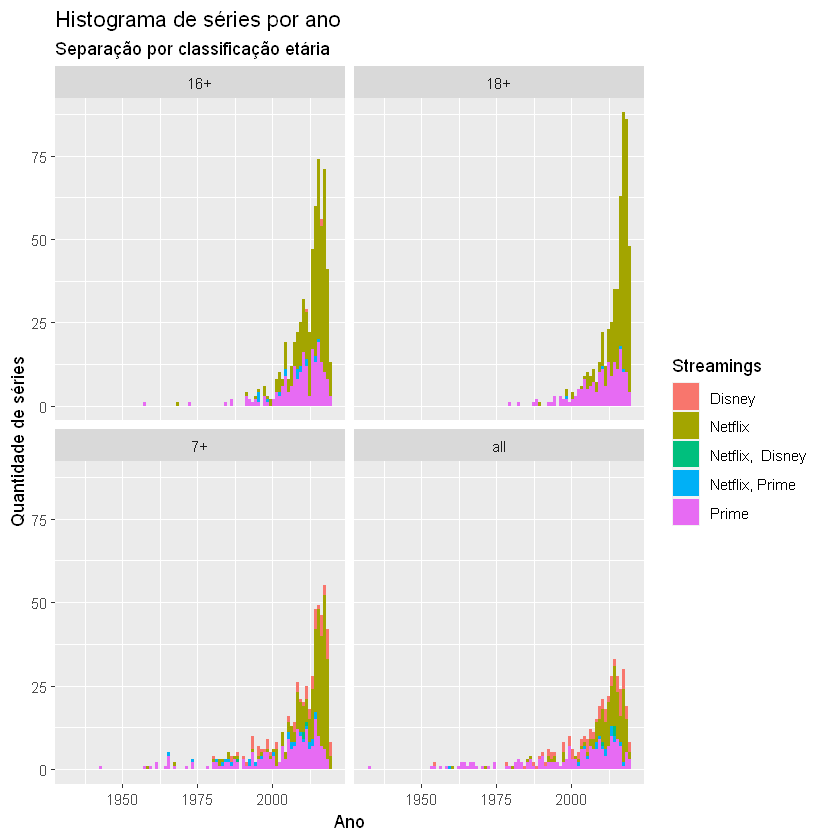

In [77]:
# Séries por ano, por faixa etária. Tirei idades 13+ (poucas séries) NA (não informativo)
cshows %>% 
filter(Age != "13+", Age != "NA") %>% 
    ggplot(aes(x = Year, fill = Streamings)) +
    geom_histogram(binwidth = 1, boundary = 0) +
    facet_wrap(~ Age, ncol = 2)+ 
    labs(x = "Ano",
    y = "Quantidade de séries",
    title = "Histograma de séries por ano",
    subtitle = "Separação por classificação etária")

Agora, uma pergunta natural é: "As séries de uma plataforma são melhores que de outra?", isto é, há alguma correlação entre a plataforma de uma série e sua nota?

Podemos ver isso abaixo, primeiro pelo IMDb

In [87]:
notas_disney <- cshows %>% filter(Streamings == "Disney", !is.na(IMDb))
var_disney <- varpop(notas_disney$IMDb)
n_disney <- length(notas_disney$IMDb)

notas_netflix <- cshows %>% filter(Streamings == "Netflix", !is.na(IMDb))
var_netflix <- varpop(notas_netflix$IMDb)
n_netflix <- length(notas_netflix$IMDb)

notas_prime <- cshows %>% filter(Streamings == "Prime", !is.na(IMDb))
var_prime <- varpop(notas_prime$IMDb)
n_prime <- length(notas_prime$IMDb)

notas_netflix_disney <- cshows %>% filter(Streamings == "Netflix,  Disney", !is.na(IMDb))
var_netflix_disney <- varpop(notas_netflix_disney$IMDb)
n_netflix_disney <- length(notas_netflix_disney$IMDb)

notas_netflix_prime <- cshows %>% filter(Streamings == "Netflix, Prime", !is.na(IMDb))
var_netflix_prime <- varpop(notas_netflix_prime$IMDb)
n_netflix_prime <- length(notas_netflix_prime$IMDb)

notas <- cshows %>% filter(!is.na(IMDb))
var <- varpop(notas$IMDb)
n_IMDb <- n_disney + n_netflix + n_prime + n_netflix_disney + n_netflix_prime

var_barra <- (n_disney * var_disney + n_netflix * var_netflix + n_prime * var_prime + n_netflix_disney * var_netflix_disney + n_netflix_prime * var_netflix_prime)/n_IMDb
r² <- 1 - var_barra/var
r²

[1] 0.002629741

In [88]:
X_squared <- chisq.test(cshows$Streamings, cshows$IMDb)
X_squared[1]

Warning message in chisq.test(cshows$Streamings, cshows$IMDb):
"Chi-squared approximation may be incorrect"

$statistic
X-squared 
 331.1682

In [89]:
C = sqrt(unname(X_squared[["statistic"]])/(length(cshows$Streamings) + unname(X_squared[["statistic"]])))
C

[1] 0.2720622

De onde percebe-se que aproximadamente 27% da nota do IMDb pode ser explicada através da Streaming.

Podemos ver o mesmo de acordo com o Rotten Tomatoes.

In [90]:
notas_disney <- cshows %>% filter(Streamings == "Disney", !is.na(Rotten_Tomatoes))
var_disney <- varpop(notas_disney$Rotten_Tomatoes)
n_disney <- length(notas_disney$Rotten_Tomatoes)

notas_netflix <- cshows %>% filter(Streamings == "Netflix", !is.na(Rotten_Tomatoes))
var_netflix <- varpop(notas_netflix$Rotten_Tomatoes)
n_netflix <- length(notas_netflix$Rotten_Tomatoes)

notas_prime <- cshows %>% filter(Streamings == "Prime", !is.na(Rotten_Tomatoes))
var_prime <- varpop(notas_prime$Rotten_Tomatoes)
n_prime <- length(notas_prime$Rotten_Tomatoes)

notas_netflix_prime <- cshows %>% filter(Streamings == "Netflix, Prime", !is.na(Rotten_Tomatoes))
var_netflix_prime <- varpop(notas_netflix_prime$Rotten_Tomatoes)
n_netflix_prime <- length(notas_netflix_prime$Rotten_Tomatoes)

notas <- cshows %>% filter(!is.na(Rotten_Tomatoes))
var <- varpop(notas$Rotten_Tomatoes)
n_Rotten <- n_disney + n_netflix + n_prime + n_netflix_disney + n_netflix_prime

var_barra <- (n_disney * var_disney + n_netflix * var_netflix + n_prime * var_prime + n_netflix_prime * var_netflix_prime)/n_Rotten
r² <- 1 - var_barra/var
r²

[1] 0.01380825

In [91]:
X_squared <- chisq.test(cshows$Streamings, cshows$Rotten_Tomatoes)
X_squared[1]

Warning message in chisq.test(cshows$Streamings, cshows$Rotten_Tomatoes):
"Chi-squared approximation may be incorrect"

$statistic
X-squared 
 241.0393

In [92]:
C = sqrt(unname(X_squared[["statistic"]])/(length(cshows$Streamings) + unname(X_squared[["statistic"]])))
C

[1] 0.2344805

De onde percebe-se que aproximadamente 23% da nota do Rotten Tomatoes pode ser explicada através da Streaming. Aqui vale ressaltar que a quantidade de séries observadas é bem menor, conforme pode-se observar abaixo

In [95]:
print(n_IMDb)
print(n_Rotten)

[1] 3205
[1] 716


Um outro detalhe interessante de se analisar é a distribuição das notas por plataforma, assim

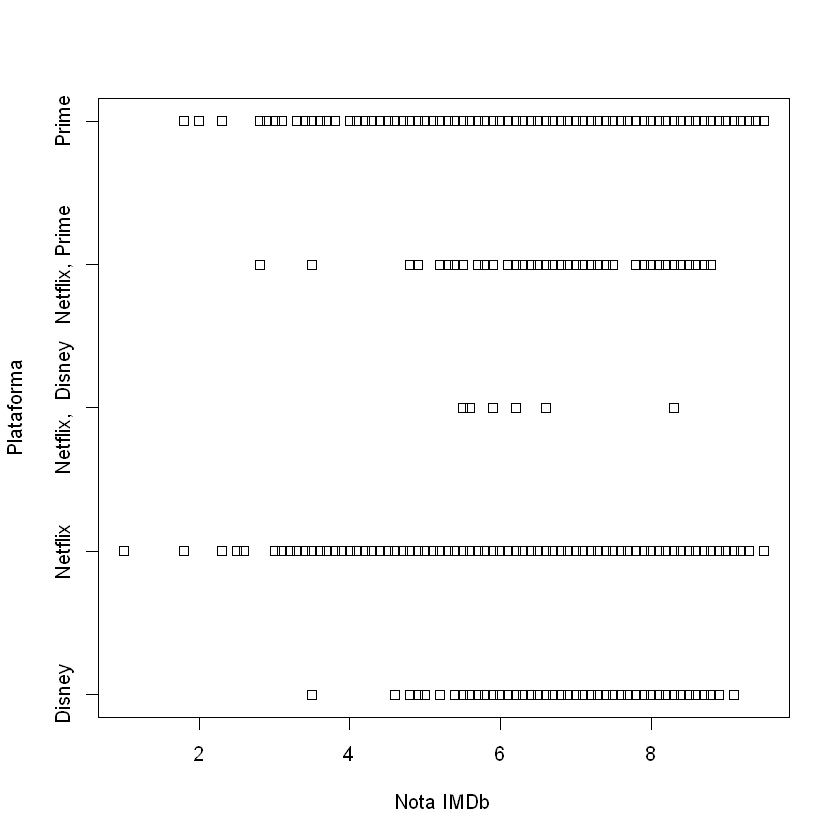

In [96]:
stripchart(cshows$IMDb ~ cshows$Streamings, xlab = "Nota IMDb", ylab = "Plataforma")

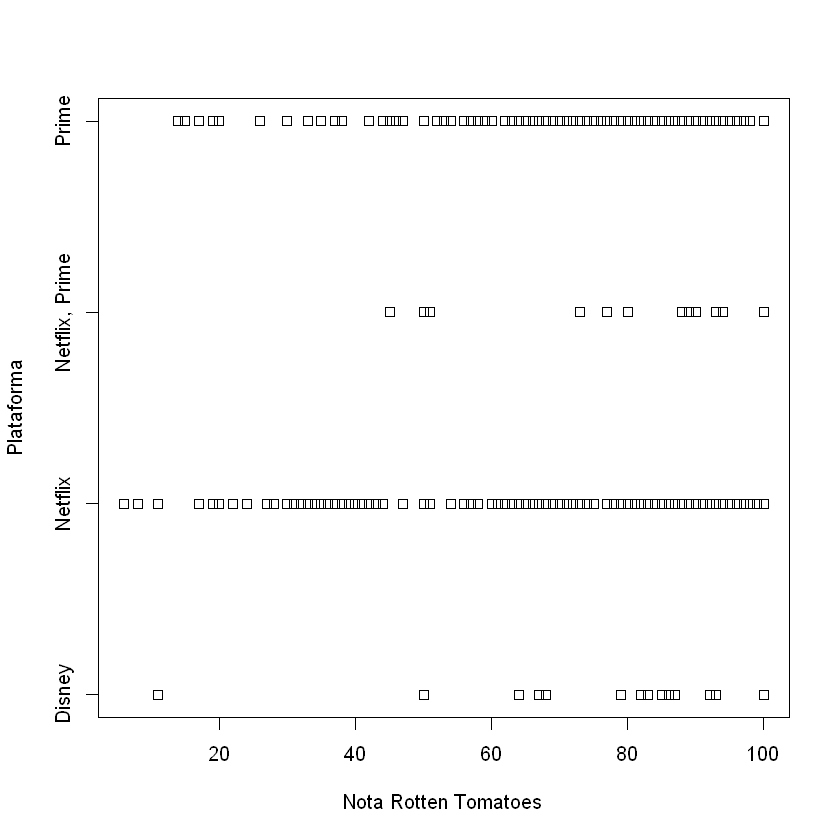

In [97]:
stripchart(cshows$Rotten_Tomatoes ~ cshows$Streamings, xlab = "Nota Rotten Tomatoes", ylab = "Plataforma")

Em virtude da quantidade de séries em plataformas como Netflix e Amazon Prime, uma melhor visualização se dá pelo boxplot dos dados

Warning message:
"Removed 938 rows containing non-finite values (stat_boxplot)."

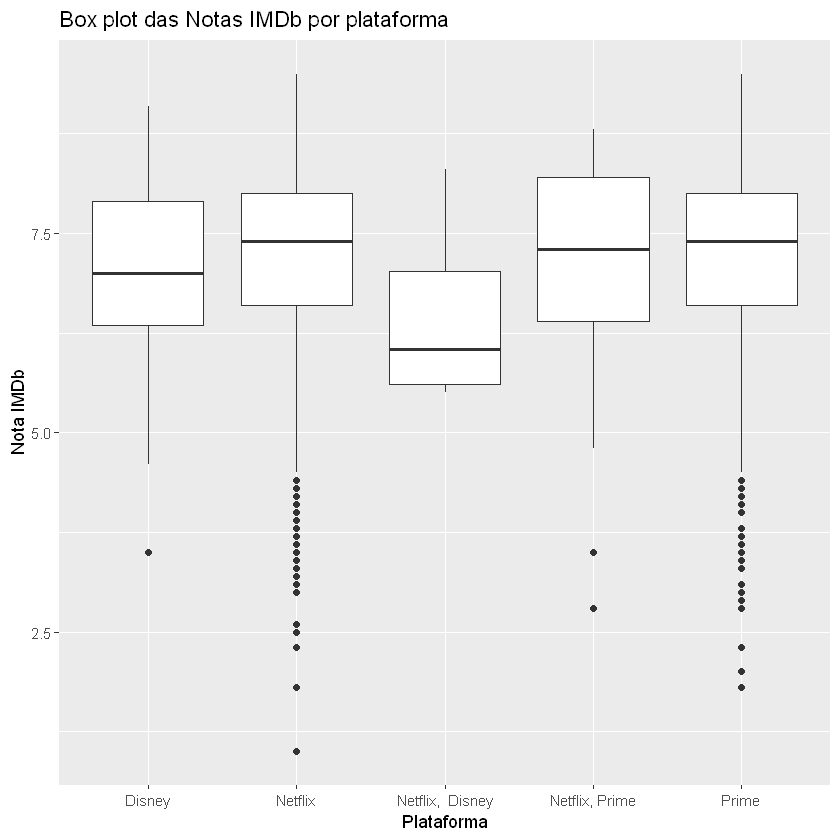

In [98]:
cshows %>% 
ggplot(aes(x = Streamings, y = IMDb)) +
geom_boxplot() +
labs(x = "Plataforma",
y = "Nota IMDb",
title = "Box plot das Notas IMDb por plataforma")

Warning message:
"Removed 3427 rows containing non-finite values (stat_boxplot)."

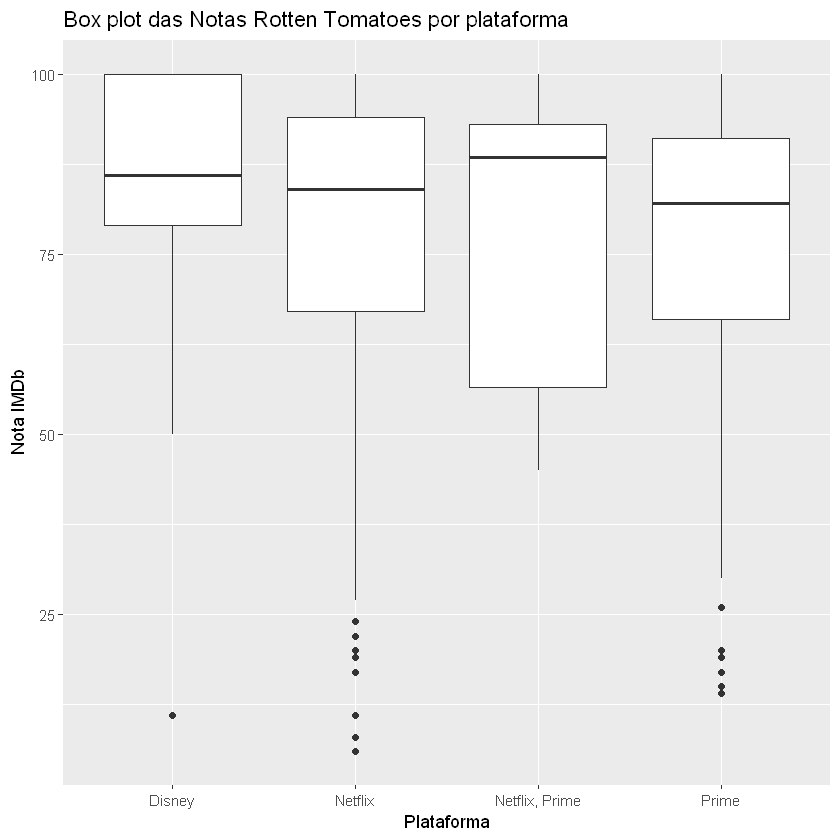

In [102]:
cshows %>% filter(Streamings != "Netflix,  Disney") %>% 
ggplot(aes(x = Streamings, y = Rotten_Tomatoes)) +
geom_boxplot() +
labs(x = "Plataforma",
y = "Nota IMDb",
title = "Box plot das Notas Rotten Tomatoes por plataforma")

Podemos também ver como as notas das séries se comportam ao comparar as duas notas obtidas.

Warning message:
"Removed 3430 rows containing missing values (geom_point)."

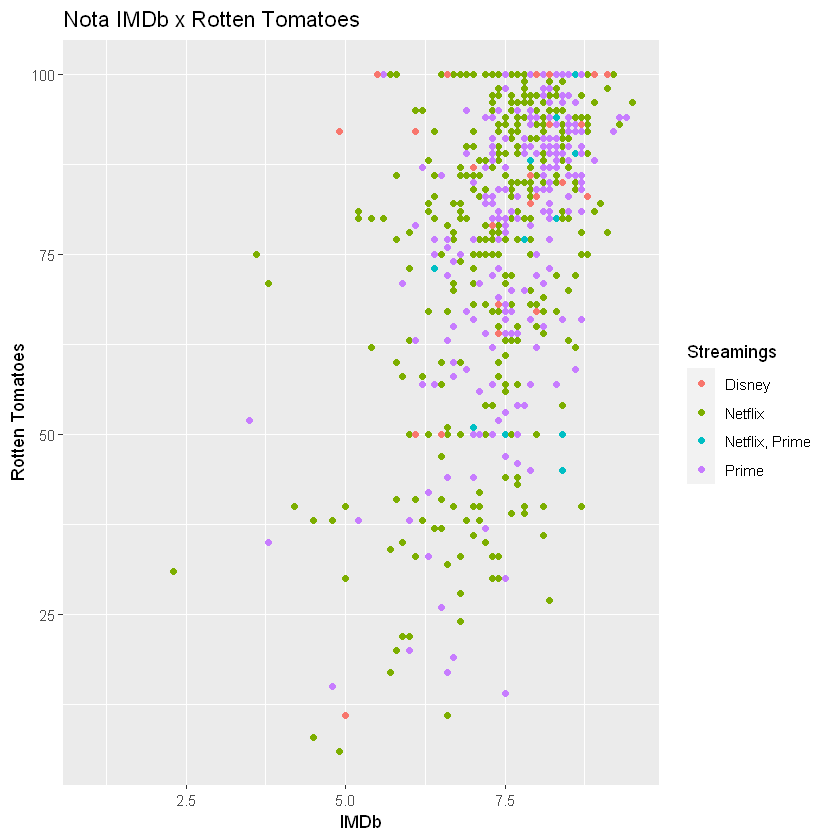

In [107]:
cshows %>% filter(Streamings != "Netflix,  Disney") %>% 
ggplot(aes(x = IMDb, y = Rotten_Tomatoes, color = Streamings)) +
labs(x = "IMDb", y = "Rotten Tomatoes", title = "Nota IMDb x Rotten Tomatoes") + 
geom_point()

Note que a análise da quantidade de séries com cada nota fica complicada nesse gráfico, dessa forma, podemos dividir as plataformas em subgráficos:

Warning message:
"Removed 3430 rows containing missing values (geom_point)."

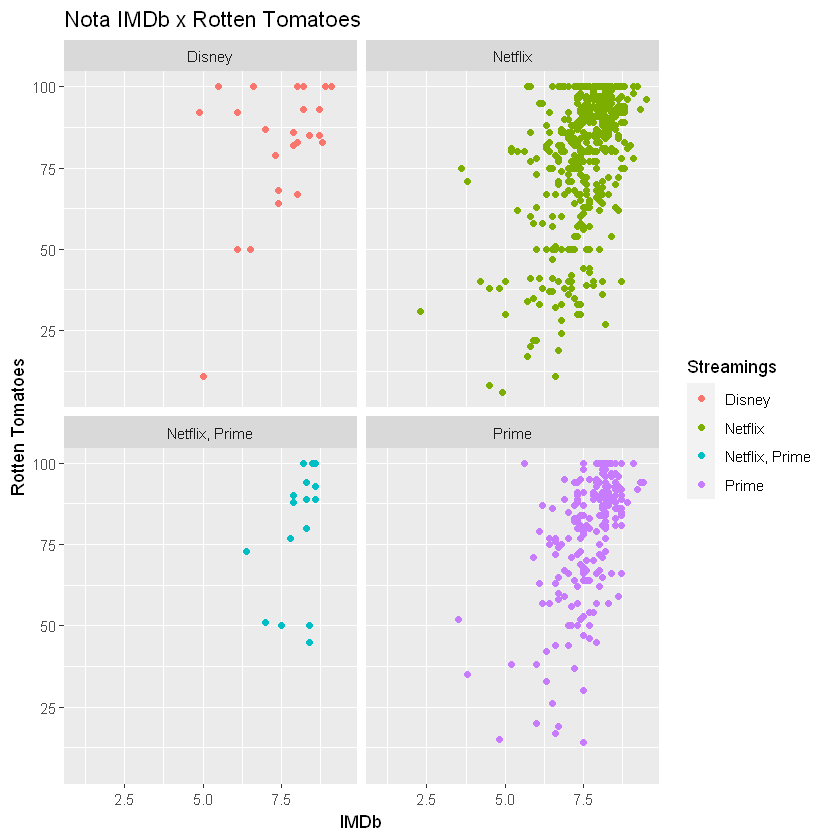

In [108]:
cshows %>% filter(Streamings != "Netflix,  Disney") %>% 
ggplot(aes(x = IMDb, y = Rotten_Tomatoes, color = Streamings)) +
labs(x = "IMDb", y = "Rotten Tomatoes", title = "Nota IMDb x Rotten Tomatoes") + 
geom_point() +
facet_wrap(~ Streamings, ncol = 2)

In [20]:
glimpse(cshows)

Rows: 4,143
Columns: 7
$ Title           <chr> "Breaking Bad", "Stranger Things", "Money Heist", "She~
$ Year            <dbl> 2008, 2016, 2017, 2010, 2015, 2005, 2011, 2005, 2005, ~
$ Age             <chr> "18+", "16+", "18+", "16+", "18+", "16+", "18+", "16+"~
$ IMDb            <dbl> 9.5, 8.8, 8.4, 9.1, 8.7, 8.9, 8.8, 8.4, 8.4, 8.8, 9.2,~
$ Rotten_Tomatoes <dbl> 96, 93, 91, 78, 97, 81, 83, 93, 93, 92, 100, 81, 94, 8~
$ Streamings      <chr> "Netflix", "Netflix", "Netflix", "Netflix", "Netflix",~
$ Genre           <chr> "Crime TV Shows, TV Dramas, TV Thrillers", "TV Horror,~
